In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import seaborn as sns
import plotly.express as px

In [ ]:
df = pd.read_csv("Smart cities dataset CSV M.csv")
df.head()

Date/Time (LST)  Month  Day Time (LST)  Temp (°C)  Dew Point Temp (°C)  \
0   1/1/2023 1:00      1    1       1:00        3.0                  3.0   
1   1/1/2023 2:00      1    1       2:00        3.0                  3.0   
2   1/1/2023 3:00      1    1       3:00        2.6                  2.6   
3   1/1/2023 4:00      1    1       4:00        2.4                  2.4   
4   1/1/2023 5:00      1    1       5:00        2.1                  2.1   

   Rel Hum (%)  Wind Dir (10s deg)  Wind Spd (km/h)  Visibility (km)  \
0        100.0                26.0             10.0              0.4   
1        100.0                30.0             21.0              6.4   
2        100.0                28.0             24.0              8.1   
3        100.0                28.0             23.0             11.3   
4        100.0                28.0             24.0             11.3   

   Stn Press (kPa)  Hmdx  Wind Chill Weather  FSS Main  
0            99.16   NaN         NaN     Fog   350.991  
1            99.22   NaN         NaN     Fog   352.707  
2            99.27   NaN         NaN     Fog   349.177  
3            99.33   NaN         NaN  Cloudy   349.923  
4            99.39   NaN         NaN     NaN   351.596

In [ ]:
df.isnull().sum()*100/df.shape[0]

Date/Time (LST)         0.000000
Month                   0.000000
Day                     0.000000
Time (LST)              0.000000
Temp (°C)               0.022841
Dew Point Temp (°C)     0.022841
Rel Hum (%)             0.022841
Wind Dir (10s deg)      0.068524
Wind Spd (km/h)         0.022841
Visibility (km)         0.022841
Stn Press (kPa)         0.022841
Hmdx                   86.797624
Wind Chill             71.208314
Weather                53.186386
FSS Main                0.000000
dtype: float64

In [ ]:
from sklearn.impute import SimpleImputer
columns_to_impute = ['Dew Point Temp (°C)', 'Temp (°C)', 'Rel Hum (%)',
                     'Wind Dir (10s deg)', 'Wind Spd (km/h)',
                     'Visibility (km)', 'Stn Press (kPa)','Wind Chill']
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(df[columns_to_impute])
df[columns_to_impute] = imp_mean.transform(df[columns_to_impute])

In [ ]:
columns_to_drop = ['Hmdx', 'Weather','Date/Time (LST)']
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
split_time = df['Time (LST)'].str.split(':', expand=True)
df['Time (LST)'] = split_time[0]
df['Time (LST)'] = pd.to_numeric(df['Time (LST)'])

In [ ]:
df.head()

Month  Day  Time (LST)  Temp (°C)  Dew Point Temp (°C)  Rel Hum (%)  \
0      1    1           1        3.0                  3.0        100.0   
1      1    1           2        3.0                  3.0        100.0   
2      1    1           3        2.6                  2.6        100.0   
3      1    1           4        2.4                  2.4        100.0   
4      1    1           5        2.1                  2.1        100.0   

   Wind Dir (10s deg)  Wind Spd (km/h)  Visibility (km)  Stn Press (kPa)  \
0                26.0             10.0              0.4            99.16   
1                30.0             21.0              6.4            99.22   
2                28.0             24.0              8.1            99.27   
3                28.0             23.0             11.3            99.33   
4                28.0             24.0             11.3            99.39   

   Wind Chill  FSS Main  
0  -10.919873   350.991  
1  -10.919873   352.707  
2  -10.919873   349.177  
3  -10.919873   349.923  
4  -10.919873   351.596

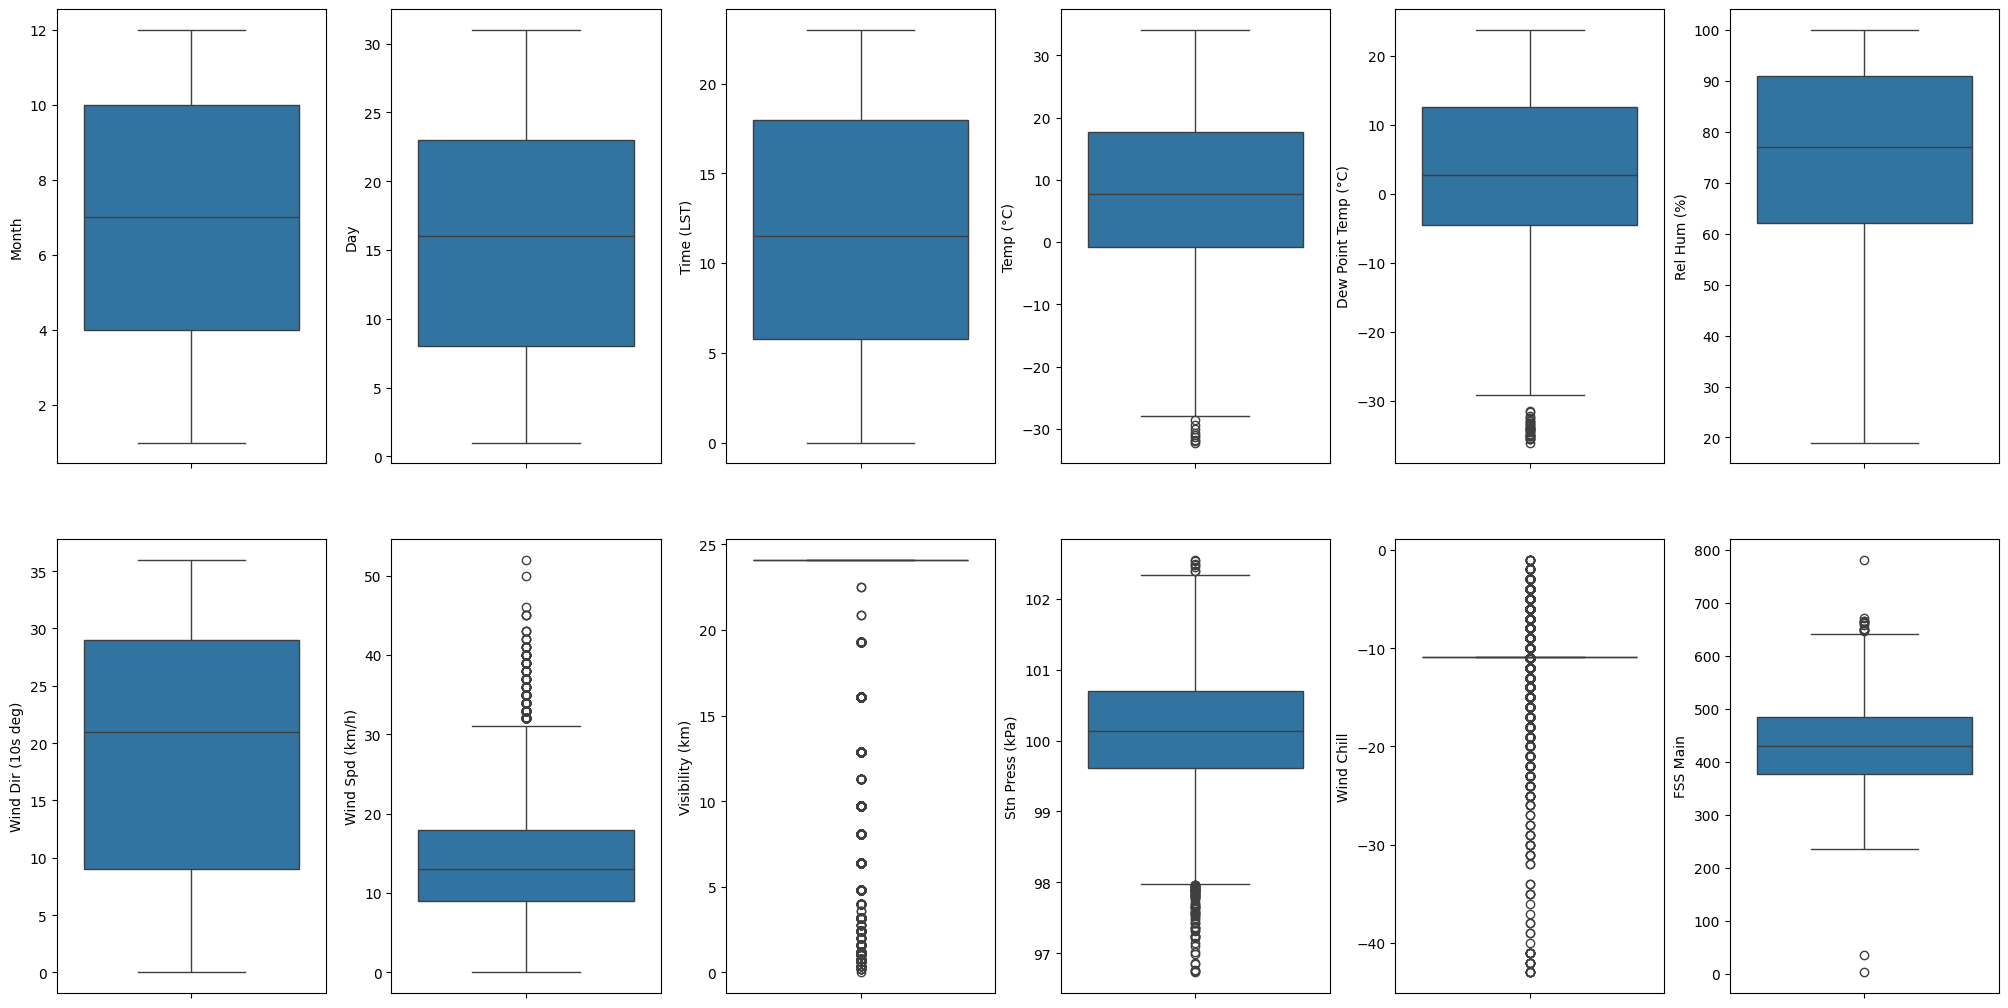

In [ ]:
from scipy import stats

fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
columns_to_drop = ['Wind Chill', 'Visibility (km)']
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df['Time (LST)'] = pd.to_numeric(df['Time (LST)'])
for k, v in df.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column Month outliers = 0.00%
Column Day outliers = 0.00%
Column Time (LST) outliers = 0.00%
Column Temp (°C) outliers = 0.10%
Column Dew Point Temp (°C) outliers = 0.37%
Column Rel Hum (%) outliers = 0.00%
Column Wind Dir (10s deg) outliers = 0.00%
Column Wind Spd (km/h) outliers = 3.13%
Column Stn Press (kPa) outliers = 0.89%
Column FSS Main outliers = 0.17%


In [ ]:
columns_to_process = [
      'FSS Main','Wind Spd (km/h)','Temp (°C)', 'Dew Point Temp (°C)',
    'Rel Hum (%)',  'Stn Press (kPa)']

for column in columns_to_process:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
    perc_outliers = len(outliers) * 100.0 / len(df[column])

    print(f"Column '{column}' outliers = {perc_outliers:.2f}%")
    print(f"Number of outliers in '{column}':", len(outliers))
    print(f"Lower bound for '{column}': {lower_bound}, Upper bound for '{column}': {upper_bound}")
    print('')

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

Column 'FSS Main' outliers = 0.17%
Number of outliers in 'FSS Main': 15
Lower bound for 'FSS Main': 218.2055000000001, Upper bound for 'FSS Main': 643.7114999999999

Column 'Wind Spd (km/h)' outliers = 3.08%
Number of outliers in 'Wind Spd (km/h)': 269
Lower bound for 'Wind Spd (km/h)': -4.5, Upper bound for 'Wind Spd (km/h)': 31.5

Column 'Temp (°C)' outliers = 0.11%
Number of outliers in 'Temp (°C)': 9
Lower bound for 'Temp (°C)': -28.299999999999997, Upper bound for 'Temp (°C)': 45.3

Column 'Dew Point Temp (°C)' outliers = 0.08%
Number of outliers in 'Dew Point Temp (°C)': 7
Lower bound for 'Dew Point Temp (°C)': -30.050000000000004, Upper bound for 'Dew Point Temp (°C)': 38.35

Column 'Rel Hum (%)' outliers = 0.00%
Number of outliers in 'Rel Hum (%)': 0
Lower bound for 'Rel Hum (%)': 18.5, Upper bound for 'Rel Hum (%)': 134.5

Column 'Stn Press (kPa)' outliers = 0.88%
Number of outliers in 'Stn Press (kPa)': 74
Lower bound for 'Stn Press (kPa)': 97.98500000000001, Upper bound for 

In [ ]:
df.head()

Month  Day  Time (LST)  Temp (°C)  Dew Point Temp (°C)  Rel Hum (%)  \
0      1    1           1        3.0                  3.0        100.0   
1      1    1           2        3.0                  3.0        100.0   
2      1    1           3        2.6                  2.6        100.0   
3      1    1           4        2.4                  2.4        100.0   
4      1    1           5        2.1                  2.1        100.0   

   Wind Dir (10s deg)  Wind Spd (km/h)  Stn Press (kPa)  FSS Main  
0                26.0             10.0            99.16   350.991  
1                30.0             21.0            99.22   352.707  
2                28.0             24.0            99.27   349.177  
3                28.0             23.0            99.33   349.923  
4                28.0             24.0            99.39   351.596

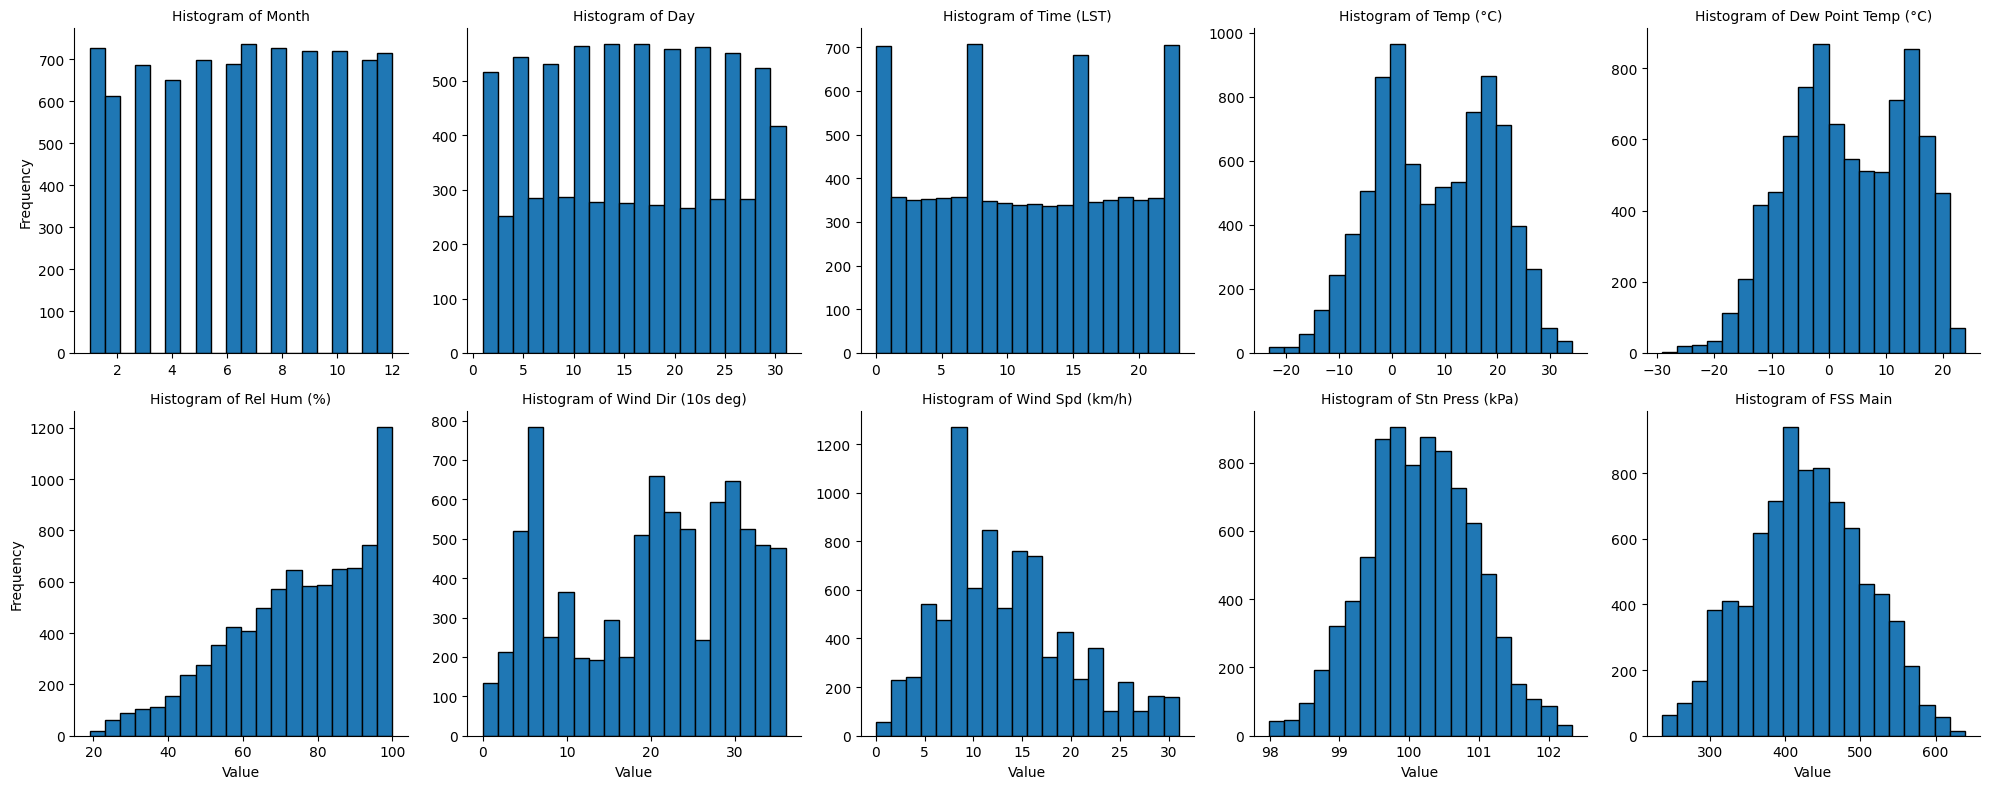

In [ ]:
grid = sns.FacetGrid(df.melt(var_name='Column'), col='Column', col_wrap=5, sharex=False, sharey=False, height=4)

# Map histograms to each subplot
grid.map(plt.hist, 'value', bins=20, edgecolor='black')

# Set labels and titles
grid.set_axis_labels('Value', 'Frequency')
grid.set_titles('Histogram of {col_name}')

plt.tight_layout()
plt.show()

<Axes: >

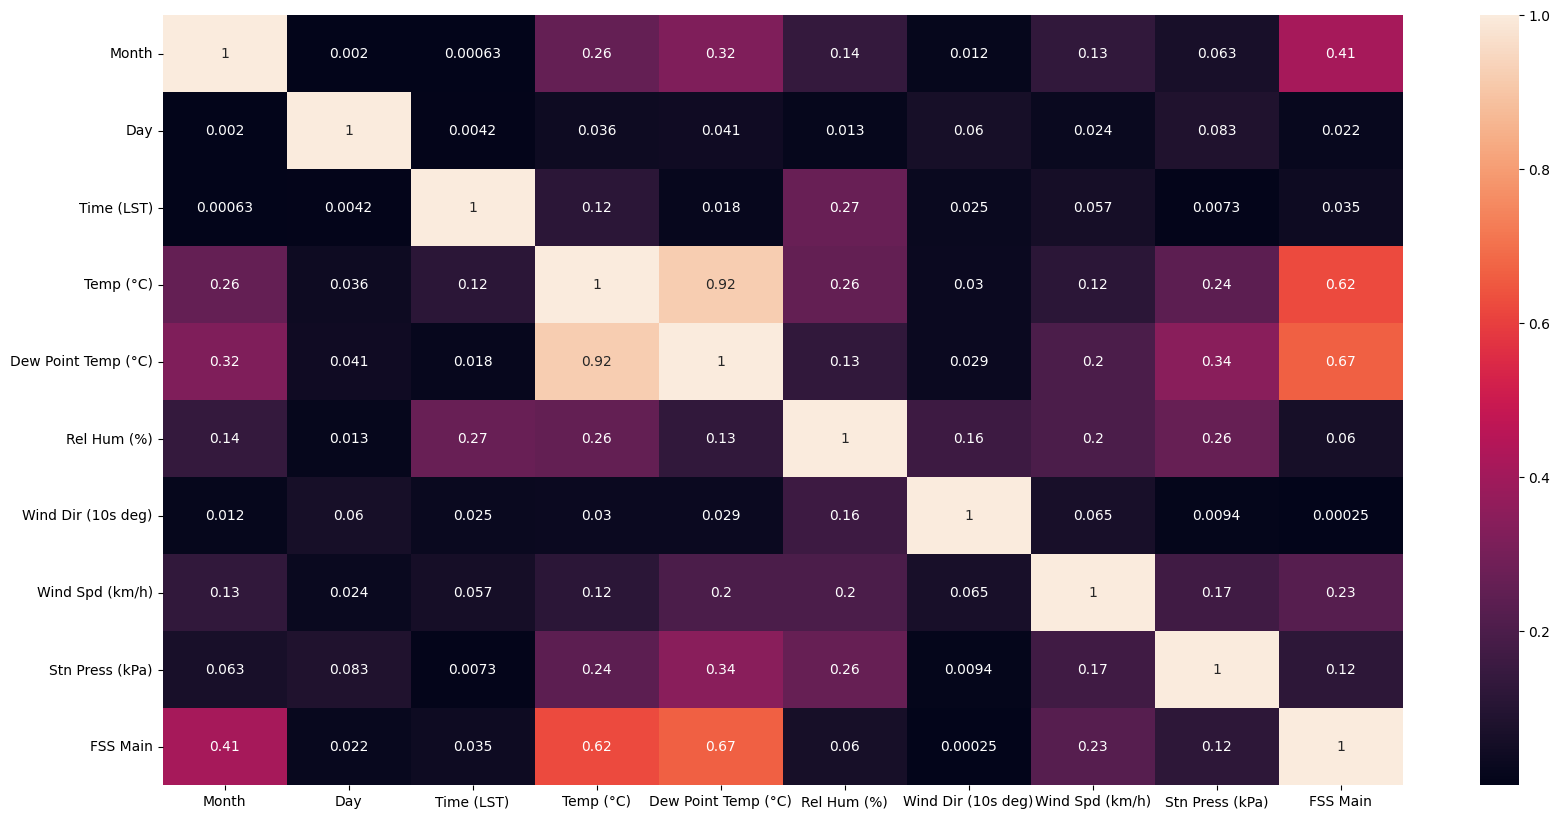

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(), annot = True)

In [ ]:
fig = px.scatter(df, x='Month', y="FSS Main", trendline="ols", title= 'Month')
fig.show()

In [ ]:
for label in df.columns[:-1]:
  if label != "chas":
    fig = px.scatter(df, x=label, y="FSS Main", trendline="ols", title= label)
    fig.show()

In [ ]:
x = df.iloc[:,:-1].values
y = df.iloc[:,9].values

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.20, random_state = 42)

In [ ]:
ss = StandardScaler()
ss.fit(x_train)

StandardScaler()

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression()

In [ ]:
y_pred = regressor.predict(x_test)
y_pred

array([438.33861404, 466.54532842, 370.72046574, ..., 363.14556485,
       383.79045734, 448.45076312])

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2}')

R² score: 0.5050841295096491


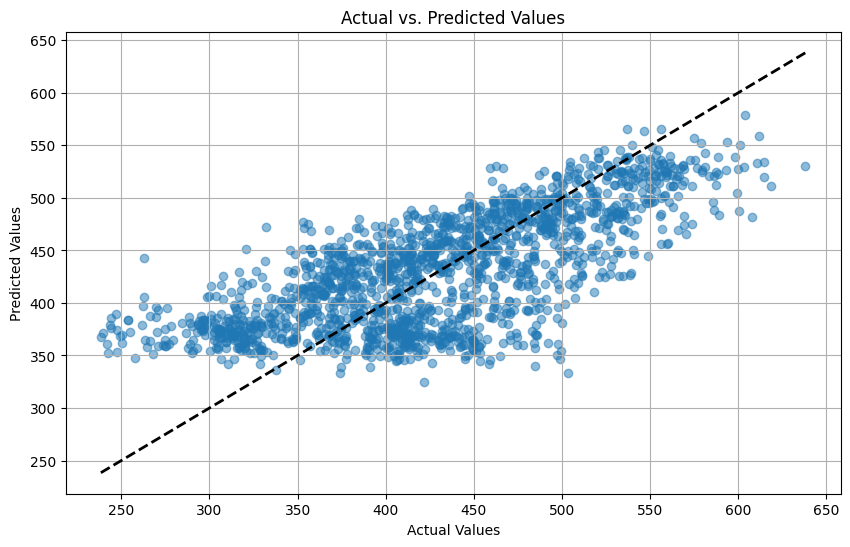

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

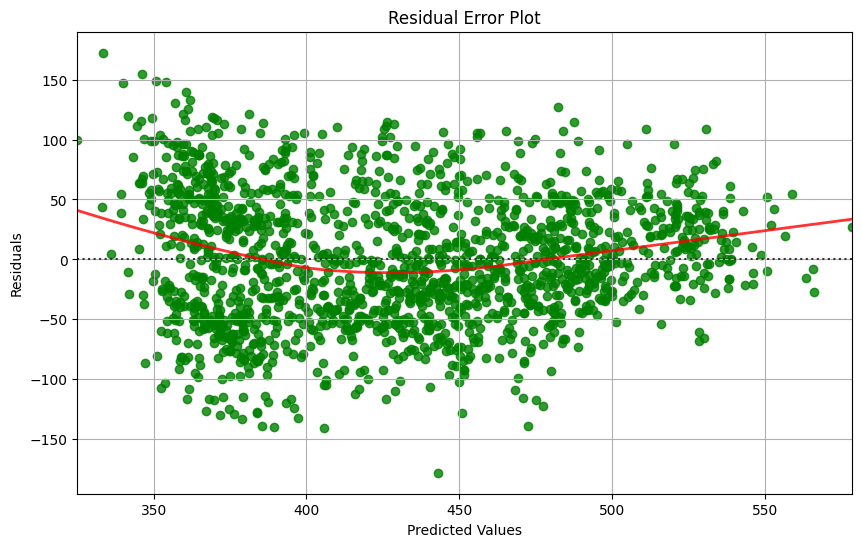

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g",
              line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Error Plot')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

cv_scores = cross_val_score(regressor, x, y, cv=kf, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-cv_scores)

for i, score in enumerate(rmse_scores):
    print(f"Fold {i+1} RMSE: {score}")

mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE: {mean_rmse}")

Fold 1 RMSE: 53.42226140303056
Fold 2 RMSE: 54.53555728428655
Fold 3 RMSE: 53.4588423373807
Fold 4 RMSE: 53.76998418561418
Fold 5 RMSE: 54.24404849653746

Mean RMSE: 53.88613874136989


In [ ]:
avg_actual = np.mean(y)
rmse_percentage = (mean_rmse / avg_actual) * 100
print(f"Mean RMSE as a percentage of the average actual value: {rmse_percentage}%")

Mean RMSE as a percentage of the average actual value: 12.571791920624667%


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(learning_rate=0.001, max_iter= 10000)
model.fit(x_train, y_train)

HistGradientBoostingRegressor(learning_rate=0.001, max_iter=10000)

In [ ]:
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2}')

R² score: 0.8669038341409734


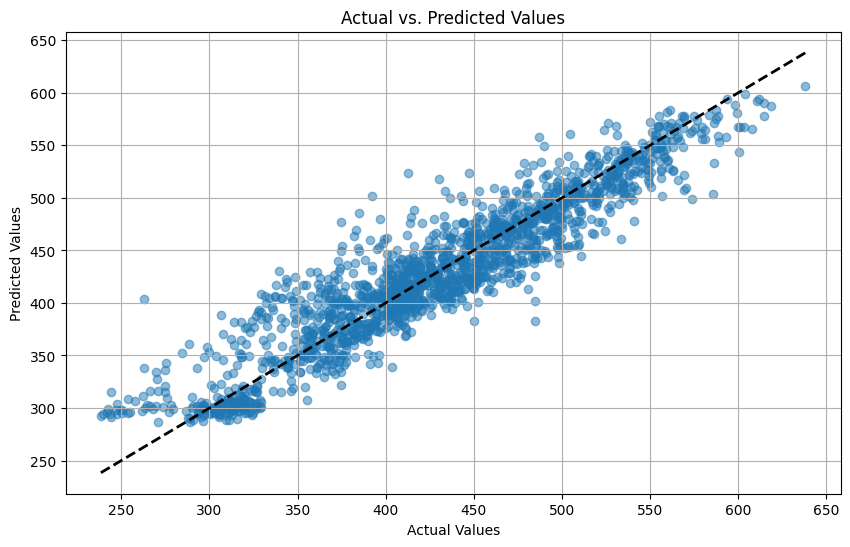

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

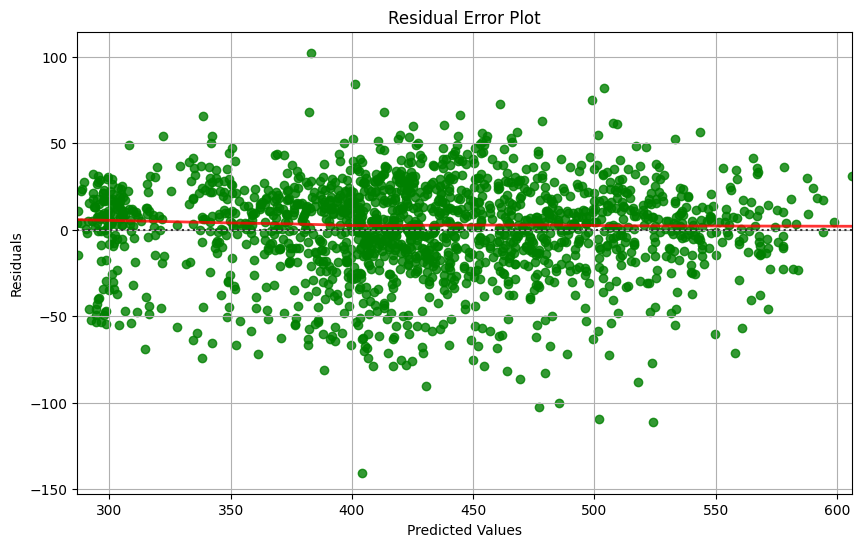

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g",
              line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Error Plot')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, x, y, cv=kf, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-cv_scores)

for i, score in enumerate(rmse_scores):
    print(f"Fold {i+1} RMSE: {score}")

mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE: {mean_rmse}")

Fold 1 RMSE: 27.703800440539233
Fold 2 RMSE: 27.95486209870969
Fold 3 RMSE: 27.968956351994084
Fold 4 RMSE: 27.89913372593815
Fold 5 RMSE: 27.774009134007493

Mean RMSE: 27.86015235023773


In [ ]:
avg_actual = np.mean(y)
rmse_percentage = (mean_rmse / avg_actual) * 100
print(f"Mean RMSE as a percentage of the average actual value: {rmse_percentage}%")

Mean RMSE as a percentage of the average actual value: 6.499854070174687%


In [ ]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor(n_estimators=5000, random_state=42)
model2.fit(x_train, y_train)

RandomForestRegressor(n_estimators=5000, random_state=42)

In [ ]:
y_pred = model2.predict(x_test)
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2}')

R² score: 0.8747561112939812


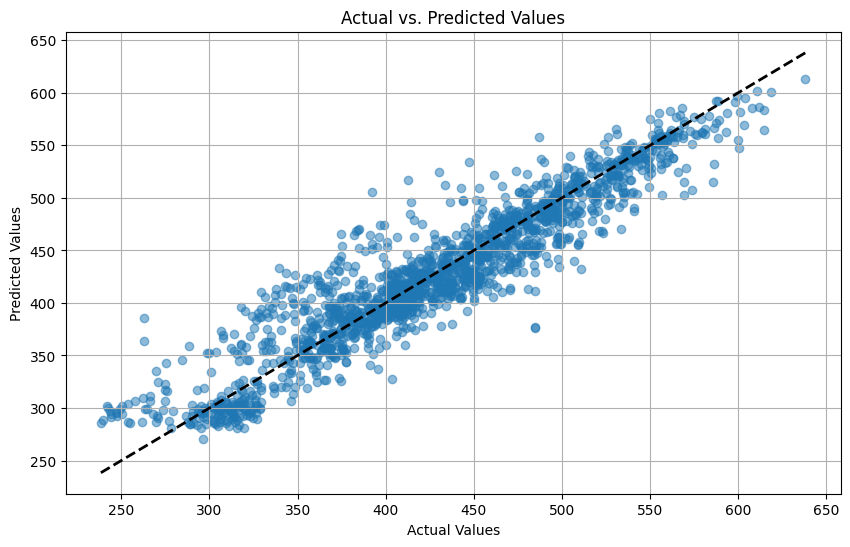

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
# Plotting the identity line for reference
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

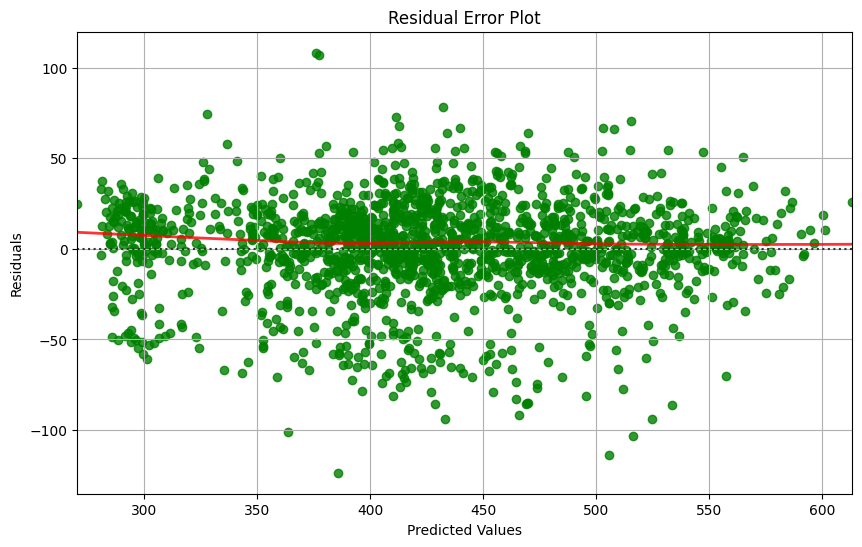

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g",
              line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Error Plot')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

cv_scores = cross_val_score(model2, x, y, cv=kf, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-cv_scores)

for i, score in enumerate(rmse_scores):
    print(f"Fold {i+1} RMSE: {score}")

mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE: {mean_rmse}")

Fold 1 RMSE: 26.88246880831028
Fold 2 RMSE: 27.32429005618475
Fold 3 RMSE: 28.790752672187587
Fold 4 RMSE: 28.044649652239833
Fold 5 RMSE: 27.715281095970607

Mean RMSE: 27.75148845697861


In [ ]:
avg_actual = np.mean(y)
rmse_percentage = (mean_rmse / avg_actual) * 100

print(f"Mean RMSE as a percentage of the average actual value: {rmse_percentage}%")

Mean RMSE as a percentage of the average actual value: 6.474502469795687%
